In [165]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sp
import scipy.optimize as op
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import normalize
from sklearn.linear_model import LinearRegression, Ridge

### Visualizing example dataset for outlier detection

In [166]:
path="H:/assignments/machine_learning/mex8/machine-learning-ex8/ex8/"
data=sp.loadmat(path+'ex8data1.mat')
def plotData(X):
    plt.scatter(X[:,0],X[:,1],marker='x',c='r')
    plt.xlabel('Latency (ms)')
    plt.ylabel('Throughput (mb/s)')
    return plt


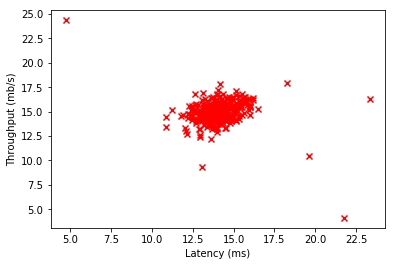

In [167]:
X=data['X']
yval=data['yval']
Xval=data['Xval']
plotData(X).show()
plt.close()

### Estimating the parameters of our assumed Gaussian distribution

In [168]:
def estimate_gaussian(X,MV=True):
        m=X.shape[0]
        mu=np.sum(X,axis=0)/m
        if not MV:
            sigma2=np.sum(np.square(X-mu),axis=0)/m
            return mu, sigma2
        else:
            sigma2 = ((X-mu).T.dot(X-mu))/m
            return mu, sigma2
def multivariate_gaussian(X, mu, sigma2):
    m = X.shape[0]
    n = X.shape[1]
    if np.ndim(sigma2) == 1:
        sigma2 = np.diag(sigma2)
    norm=1./(np.power((2*np.pi), n/2)*np.sqrt(np.linalg.det(sigma2)))
    ninv=np.linalg.inv(sigma2)
    myexp = np.zeros((m,1))
    for irow in range(m):
        xrow = X[irow]
#         print(np.exp(-0.5*((xrow-mu).T)).shape,(xrow-mu).shape,ninv.shape)
#   #  ,(xrow-mu),(ninv)))
        myexp[irow] = np.exp(-0.5*((xrow-mu).T).dot(ninv).dot(xrow-mu))
    return norm*myexp

In [169]:
def plot_contour(X,mu,sigma2):
    x = np.arange(0,30,0.5)
    y = np.arange(0,30,0.5)
    meshx, meshy = np.meshgrid(x,y)
    coord_list = [ entry.ravel() for entry in (meshx, meshy) ]
    points = np.vstack(coord_list).T
    z = multivariate_gaussian(points, mu, sigma2)
    #if not useMultivariate:
    #    myz = gausOrthog(points, mymu, mysigma2)
    #else: myz = gausMV(points, mymu, mysigma2)
    z = z.reshape((x.shape[0],x.shape[0]))
    cont_levels = [10**exp for exp in range(-20,0,3)]
    mycont = plt.contour(meshx, meshy, z, levels=cont_levels)
    plt.title('Gaussian Contours',fontsize=16)
    plt.show()
    
    

In [170]:
X=data['X']
y=data['yval']
mu, sigma2=estimate_gaussian(X,False)
z=multivariate_gaussian(X, mu, sigma2)


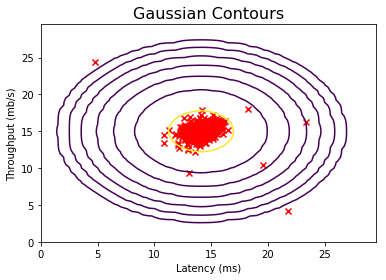

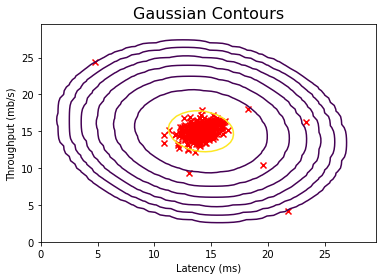

In [171]:
# First contours without using multivariate gaussian:
plotData(X)
mu, sigma2=estimate_gaussian(X,False)
plot_contour(X,mu,sigma2)
plt.close('all')
# Then contours with multivariate gaussian:
plotData(X)
mu1, sigma21=estimate_gaussian(X,True)
plot_contour(X,mu1,sigma21)
plt.close('all')

### Selecting the Threshold Value

In [172]:
def select_threshold(yval, pval):
    bestEpsilon = 0
    bestF1 = 0
    F1 = 0
    values=np.linspace(np.min(pval),np.max(pval),1000)
    for epsilon in values:
        preds = (pval < epsilon).astype('int')         
        tp = np.sum(np.logical_and(preds == 1, yval == 1)).astype(float)
        fp = np.sum(np.logical_and(preds == 1, yval == 0)).astype(float)
        fn = np.sum(np.logical_and(preds == 0, yval == 1)).astype(float) 
        prec=tp/(tp+fp)
        rec=tp/(tp+fn)
        F1=(2*prec*rec)/(prec+rec)
        if F1 > bestF1:
           bestF1 = F1
           bestEpsilon = epsilon
    return bestEpsilon,bestF1

In [173]:
Xval.shape,X.shape,yval.shape

((307, 2), (307, 2), (307, 1))

In [174]:
mu, sigma2=estimate_gaussian(X,False)
p=multivariate_gaussian(X, mu, sigma2)
pval = multivariate_gaussian(Xval, mu, sigma2)


In [175]:
(epislon,f1)=select_threshold(yval, pval)
epislon,f1

C:\Users\ankit\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


(8.9998526319013967e-05, 0.87500000000000011)

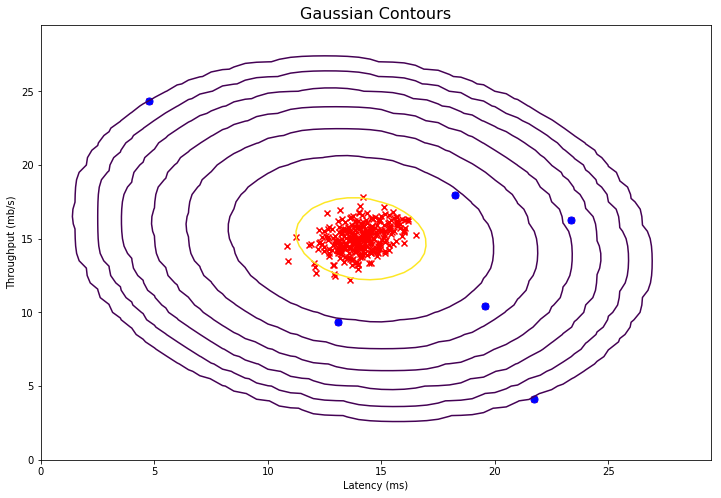

In [180]:
# indexes of the values considered to be outliers
outliers = np.where(p < epislon)
fig, ax = plt.subplots(figsize=(12,8))  
plotData(X)
ax.scatter(X[outliers[0],0], X[outliers[0],1], s=50, color='b', marker='o') 
plot_contour(X,mu1,sigma21)
plt.show()
plt.close('all')

### For multidimensional data

In [184]:
data=sp.loadmat(path+'ex8data2.mat')
X=data['X']
Xval=data['Xval']
yval=data['yval']
(mu,sigma2) = estimate_gaussian(X,False)
p = multivariate_gaussian(X, mu, sigma2)
pval = multivariate_gaussian(Xval, mu, sigma2)
(epsilon,F1) = select_threshold(yval, pval)
(epsilon,F1)

C:\Users\ankit\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


(1.3786074982000245e-18, 0.61538461538461542)

### Collaborative filtering learning on dataset of movie ratings

#### Loading and visualizing dataset

In [232]:
data=sp.loadmat(path +'ex8_movies.mat')

In [236]:
R=data['R']
Y=data['Y']
nm, nu = Y.shape

Average rating for movie 1 (Toy Story): 3.88


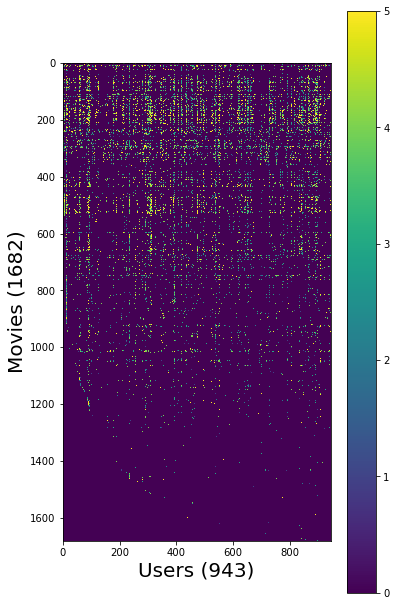

In [237]:

print ('Average rating for movie 1 (Toy Story): %0.2f' % \
np.mean([ Y[0][x] for x in range(Y.shape[1]) if R[0][x] ]))
# "Visualize the ratings matrix"
fig = plt.figure(figsize=(6,6*(1682./943.)))
plt.imshow(Y)
plt.colorbar()
plt.ylabel('Movies (%d)'%nm,fontsize=20)
plt.xlabel('Users (%d)'%nu,fontsize=20)
plt.show()
plt.close('all')

In [238]:
data2=sp.loadmat(path +'ex8_movieParams.mat')
Theta=data2['Theta']
X=data2['X']

In [253]:
def flattenParams(X, Theta):
    return np.concatenate((X.flatten(),Theta.flatten()))

# A utility function to re-shape the X and Theta will probably come in handy
def reshapeParams(flattened_XandTheta, mynm, mynu, mynf):
    assert flattened_XandTheta.shape[0] == int(mynm*mynf+mynu*mynf)
    
    reX = flattened_XandTheta[:int(mynm*mynf)].reshape((mynm,mynf))
    reTheta = flattened_XandTheta[int(mynm*mynf):].reshape((mynu,mynf))
    
    return reX, reTheta

In [329]:
def cofi_cost_func(params, Y, R, num_users, num_movies,num_features, lamb):
    X,Theta=reshapeParams(params, num_movies, num_users, num_features)
    J=np.sum(np.power(((np.dot(X,Theta.T)-Y)*R),2)/2)+\
    lamb*np.sum(np.power(Theta,2))/2+lamb*np.sum(np.power(X,2))/2
    
    return J

In [342]:
def cofi_grad(params, Y, R, num_users, num_movies,num_features, lamb=0):
    X,Theta=reshapeParams(params, num_movies, num_users, num_features)
    X_grad=np.dot(((np.dot(X,Theta.T)-Y)*R),Theta)+lamb*X
    Theta_grad =np.dot((((np.dot(X,Theta.T)-Y)*R).T),X)+lamb*Theta
    return flattenParams(X_grad, Theta_grad)

In [343]:
num_users = 4; num_movies = 5; num_features = 3;
X=X[:num_movies,:num_features]
Theta = Theta[:num_users,:num_features]
Y = Y[:num_movies,:num_users]
R = R[:num_movies,:num_users]
Y.shape

(5, 4)

In [344]:
J = cofi_cost_func(flattenParams(X, Theta), Y, R, num_users, num_movies,num_features, 0)
J

35.427225147488642

In [345]:
J = cofi_cost_func(flattenParams(X, Theta), Y, R, num_users, num_movies,num_features, 1.5)
J

40.370739525786334

### Learning movie recommendations

In [346]:
movies = []
with open(path+'movie_ids.txt') as f:
    for line in f:
        movies.append(' '.join(line.strip('\n').split(' ')[1:]))
my_ratings = np.zeros((1682,1))
my_ratings[0]   = 4
my_ratings[97]  = 2
my_ratings[6]   = 3
my_ratings[11]  = 5
my_ratings[53]  = 4
my_ratings[63]  = 5
my_ratings[65]  = 3
my_ratings[68]  = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354] = 5

In [347]:
data = sp.loadmat(path+'ex8_movies.mat')
Y = data ['Y']
R = data ['R']
# We'll use 10 features
nf = 10
Y.shape,R.shape

((1682, 943), (1682, 943))

In [348]:
# Add my ratings to the Y matrix, and the relevant row to the R matrix
myR_row = my_ratings > 0
Y = np.hstack((Y,my_ratings))
R = np.hstack((R,myR_row))
nm, nu = Y.shape

In [349]:
def normalizeRatings(Y, R):
    # The mean is only counting movies that were rated
    Ymean = np.sum(Y,axis=1)/np.sum(R,axis=1)
    Ymean = Ymean.reshape((Ymean.shape[0],1))
    return Y-Ymean, Ymean

In [350]:
Ynorm, Ymean = normalizeRatings(Y,R)

In [351]:
# Generate random initial parameters, Theta and X
X = np.random.rand(nm,nf)
Theta = np.random.rand(nu,nf)
myflat = flattenParams(X, Theta)

# Regularization parameter of 10 is used (as used in the homework assignment)
mylambda = 10.

# Training the actual model with fmin_cg
result = op.fmin_cg(cofi_cost_func, x0=myflat, fprime=cofi_grad, \
                               args=(Y,R,nu,nm,nf,mylambda), \
                                maxiter=50,disp=True,full_output=True)

         Current function value: 72870.362447
         Iterations: 50
         Function evaluations: 72
         Gradient evaluations: 72


In [352]:
# Reshape the trained output into sensible "X" and "Theta" matrices
resX, resTheta = reshapeParams(result[0], nm, nu, nf)

In [353]:
# After training the model, now make recommendations by computing
# the predictions matrix
prediction_matrix = resX.dot(resTheta.T)

In [354]:
# Grab the last user's predictions (since I put my predictions at the
# end of the Y matrix, not the front)
# Add back in the mean movie ratings
my_predictions = prediction_matrix[:,-1] + Ymean.flatten()

In [357]:
# Sort my predictions from highest to lowest
pred_idxs_sorted = np.argsort(my_predictions)
pred_idxs_sorted[:] = pred_idxs_sorted[::-1]

print ("Top recommendations for you:")
for i in range(10):
    print ('Predicting rating %0.1f for movie %s.' % \
    (my_predictions[pred_idxs_sorted[i]],movies[pred_idxs_sorted[i]]))
    
print ("\nOriginal ratings provided:")
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print ('Rated %d for movie %s.' % (my_ratings[i],movies[i]))

Top recommendations for you:
Predicting rating 8.7 for movie Star Wars (1977).
Predicting rating 8.3 for movie Shawshank Redemption, The (1994).
Predicting rating 8.3 for movie Titanic (1997).
Predicting rating 8.2 for movie Schindler's List (1993).
Predicting rating 8.2 for movie Raiders of the Lost Ark (1981).
Predicting rating 8.1 for movie Usual Suspects, The (1995).
Predicting rating 8.1 for movie Wrong Trousers, The (1993).
Predicting rating 8.1 for movie Empire Strikes Back, The (1980).
Predicting rating 8.1 for movie Close Shave, A (1995).
Predicting rating 8.1 for movie Good Will Hunting (1997).

Original ratings provided:
Rated 4 for movie Toy Story (1995).
Rated 3 for movie Twelve Monkeys (1995).
Rated 5 for movie Usual Suspects, The (1995).
Rated 4 for movie Outbreak (1995).
Rated 5 for movie Shawshank Redemption, The (1994).
Rated 3 for movie While You Were Sleeping (1995).
Rated 5 for movie Forrest Gump (1994).
Rated 2 for movie Silence of the Lambs, The (1991).
Rated 4 f